## Experiments



There are essentially two approaches that can be taken when desiring semantically similar samples to a given input: 
1. The first approach is regularizing the autoencoder in such a way that certain geometric properties are retained in the latent representation space. The research paper REGULARIZED AUTOENCODERS FOR ISOMETRIC REPRESENTATION LEARNING by Lee et. al 2022 explore this approach through isometric representation learning. 
- The results of that paper will be used to program the IRVAE.
2. The second approach utilizes the current variational autoencoder (VAE) implementations and instead tries to understand how the geometry of the latent space has changed in regards to the manifold. Specifically, most researchers view the data manifold as a Riemannian manifold, where distances are no longer Euclidean. Therefore, Riemannian metrics have to be used in order to properly determine distances between points in latent space and their respective points when projected onto the manifold. Some of the prominent papers researching this are:
- LATENT SPACE ODDITY: ON THE CURVATURE OF DEEP GENERATIVE MODELS - Arvanitidis et. al 2017
- Only Bayes should learn a manifold  - Hauberg 2018
- Metrics for Deep Generative Models - Chen et. al 2018
- Fast and Robust Shortest Paths on Manifolds Learned from Data - Arvanitidis et. al 2019 
- Geometrically Enriched Latent Spaces - Arvanitidis et. al 2020
- Mario Plays on a Manifold: Generating Functional Content in Latent Space through Differential Geometry - Gonzalez-Duque et. al 2022
- Identifying latent distances with Finslerian geometry - Pouplin et. al 2023
- Decoder ensembling for learned latent geometries - Syrota et. al 2024

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        ]
    )

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cpu")

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=0)

print(f"Using device: {device}")

Using device: cpu


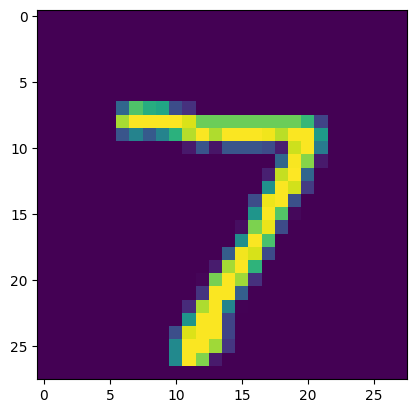

In [2]:
x_test, y_test = next(iter(test_loader))
plt.imshow(x_test.reshape((28, 28, 1)))

## Simple VAE

In [3]:
if not os.path.exists("./pretrained_models/vae.pth"):
    raise KeyError("You need to run the training notebook first.")

from models.vae import VariationalAutoencoder

hidden_dim = 2
vae = VariationalAutoencoder([28*28, 400, 200, 50], [50, 100, 200, 400, 28*28], hidden_dim=hidden_dim).to(device)
vae.load_state_dict(torch.load("./pretrained_models/vae.pth", map_location=device, weights_only=True))

<All keys matched successfully>

### Chart over Latent Space for VAE

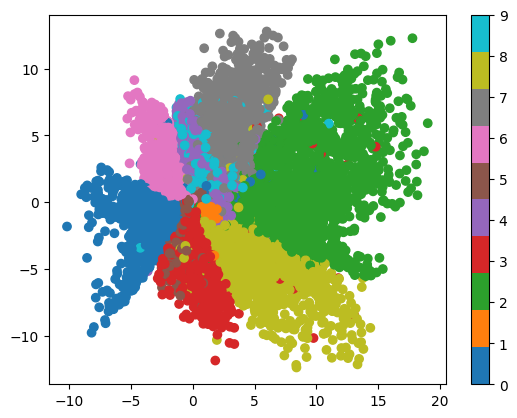

In [4]:
from utils.visualize import visualize_points_in_latent_space
visualize_points_in_latent_space(vae, train_loader)

### Gaussian Sampling of VAE

[tensor([[ 1.5386, -1.3798]], grad_fn=<AddBackward0>), tensor([[1.6749, 8.4898]], grad_fn=<AddBackward0>), tensor([[0.8446, 6.4989]], grad_fn=<AddBackward0>), tensor([[1.5708, 2.5881]], grad_fn=<AddBackward0>), tensor([[1.3188, 5.2092]], grad_fn=<AddBackward0>)]


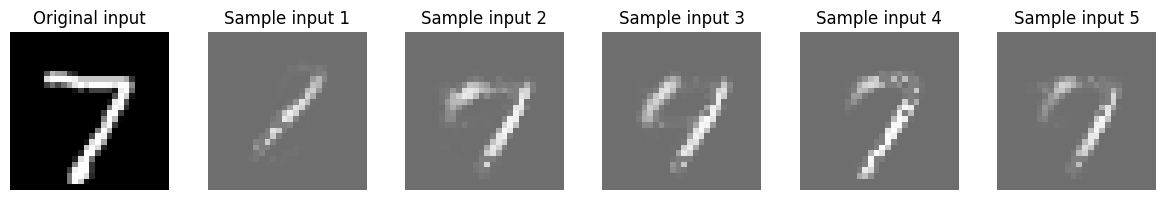

In [11]:
from utils.sampling import gaussian_sampling
from utils.visualize import visualize_samples
gaussian_samples = gaussian_sampling(vae, x_test, device, num_samples=5, scale=1e2) # I should be getting pretty close to the original input as samples... 

visualize_samples(x_test, gaussian_samples)

### Metric-Aware Sampling of VAE

## VAE with RBF for uncertainty

In [3]:
import os
if not os.path.exists("./pretrained_models/vae.pth"):
    raise KeyError("You need to run the training notebook first.")

from models.vae import VariationalAutoencoder
from models.rbf import RBFNet

import numpy as np

hidden_dim = 2
vae = VariationalAutoencoder([28*28, 400, 200, 50], [50, 100, 200, 400, 28*28], hidden_dim=hidden_dim).to(device)
vae.load_state_dict(torch.load("./pretrained_models/vae.pth", map_location=device, weights_only=True))

z_train_np = torch.load("pretrained_models/z_train.pt")
num_clusters = 16
a = 0.85

rbf = RBFNet(z_train_np, output_dim=28*28, K=num_clusters, a=a)
rbf.load_state_dict(torch.load("pretrained_models/RBF.pth"))

<All keys matched successfully>

### Gaussian Sampling

The VAE is the same trained model as the last section.

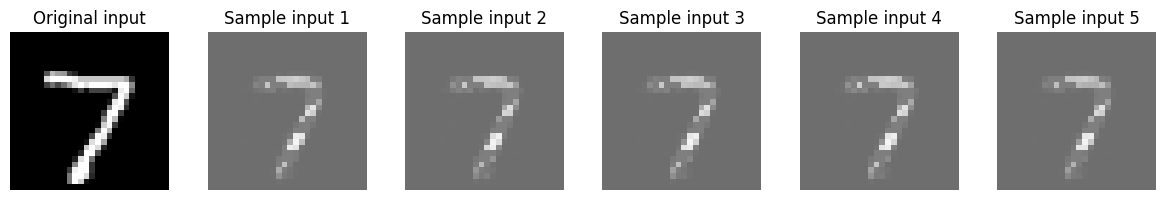

In [5]:
from utils.sampling import gaussian_sampling
from utils.visualize import visualize_samples
gaussian_samples = gaussian_sampling(vae, x_test, device, num_samples=5, scale=1e2) # I should be getting pretty close to the original input as samples... 

visualize_samples(x_test, gaussian_samples)

### Gaussian Sampling of Output
Since the decoder now explicitly contains variance, we can leverage this to sample from a Gaussian with mean from the mean decoder and variance from the variance decoder. In other words, unlike the simple VAE, the Gaussian will have heteroscedastic variance, dependent on the input.

[tensor([[[9.1500e-02, 7.2147e-02, 9.1215e-02, 6.8747e-02, 5.9719e-02,
          7.2925e-02, 8.2319e-02, 6.4245e-02, 4.9996e-02, 9.4505e-02,
          1.0081e-01, 9.3678e-02, 8.0122e-02, 8.2419e-02, 1.3472e-01,
          5.6562e-02, 5.8011e-02, 9.2202e-02, 5.0849e-02, 6.9034e-02,
          8.3194e-02, 8.0398e-02, 1.2524e-01, 6.4940e-02, 6.2389e-02,
          6.6442e-02, 7.5049e-02, 5.8718e-02, 8.7136e-02, 6.1472e-02,
          8.9856e-02, 8.8027e-02, 1.1891e-01, 1.1449e-01, 1.3932e-01,
          1.1200e-01, 5.0072e-02, 1.4917e-01, 1.0888e-01, 1.6292e-01,
          1.4614e-01, 5.9934e-02, 7.7143e-02, 6.8133e-02, 6.1923e-02,
          1.3111e-01, 9.3638e-02, 7.4613e-02, 1.9361e-01, 6.3971e-02,
          5.6217e-02, 8.1296e-02, 9.4177e-02, 8.1681e-02, 6.4179e-02,
          1.7088e-01, 7.0216e-02, 6.5489e-02, 5.2645e-02, 1.0251e-01,
          4.9006e-02, 5.0328e-02, 8.3684e-02, 8.9742e-02, 6.4422e-02,
          6.5908e-02, 1.3355e-01, 4.8575e-02, 5.0208e-02, 4.1934e-02,
          1.0993e-0

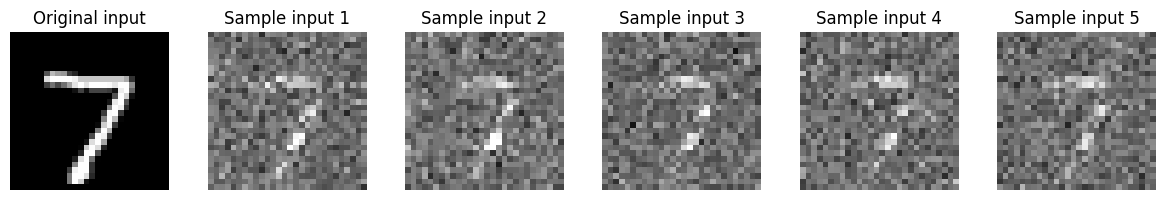

In [4]:
from utils.sampling import gaussian_sampling_rbf
from utils.visualize import visualize_samples

# x_hat, z, _, _ = vae(x_test)
# print(rbf(z).shape)
# print(x_hat.shape)
gaussian_samples = gaussian_sampling_rbf(vae, rbf, x_test, device, num_samples=5, scale=1e-1) # I should be getting pretty close to the original input as samples... 
# rbf()
visualize_samples(x_test, gaussian_samples)

### Metric-Aware Sampling
Here, the random manifold created from the uncertainty in the decoder function removes problems with a smoother manifold. As shown in research such as that proposed in the Differential Geometry textbook by Hauberg, deterministic manifolds are smoother (one of the goals and therefore side effects of regularizing neural networks). However, with smoother manifolds, holes and valleys that should appear in areas without data makes geodesics and the Riemannian metric inconsistent/incorrect. However, it was found that random manifolds come closer to the true manifold in this sense by stretching the distances in areas with higher uncertainty. This motivates geodesics to form on the manifold in low uncertainty areas. Still, the metric from such manifolds was shown to not be Riemannian in nature but rather Finslerian (shown by Pouplin et. al 2023).

## Gaussian-VAE

## Isometric Representation VAE (IRVAE)

In [3]:
from models.irvae import IRVAE

hidden_dim = 2
irvae = IRVAE([28*28, 400, 200, 50], [50, 100, 200, 400, 28*28]).to(device)
irvae.load_state_dict(torch.load("./pretrained_models/irvae.pth", map_location=device, weights_only=True))

<All keys matched successfully>

### Chart over Latent space for IRVAE

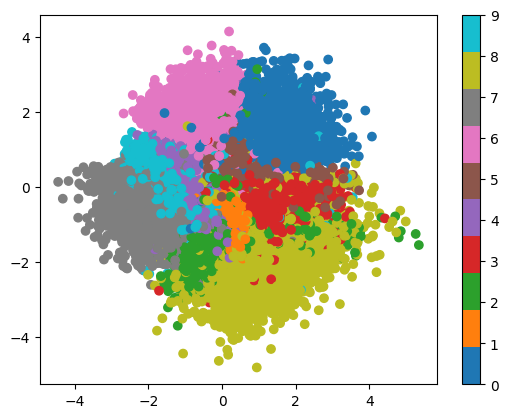

In [8]:
from utils.visualize import visualize_points_in_latent_space
visualize_points_in_latent_space(irvae, train_loader)

### Gaussian Sampling of IRVAE

[tensor([[-1.3508, -0.3398]], grad_fn=<AddBackward0>), tensor([[-2.7405,  0.4777]], grad_fn=<AddBackward0>), tensor([[-2.5867, -1.2738]], grad_fn=<AddBackward0>), tensor([[-1.1401, -1.4399]], grad_fn=<AddBackward0>), tensor([[-3.1232, -0.7443]], grad_fn=<AddBackward0>)]


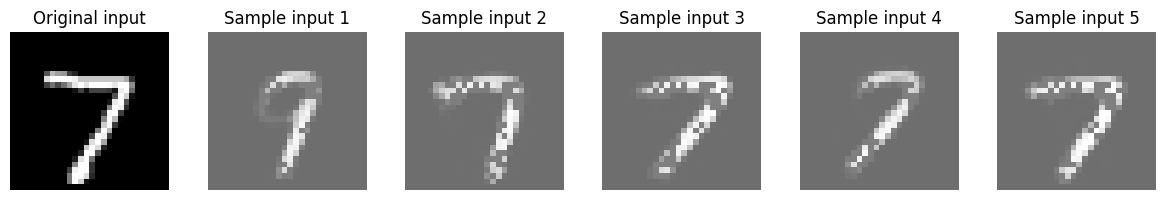

In [18]:
from utils.sampling import gaussian_sampling
from utils.visualize import visualize_samples
gaussian_samples = gaussian_sampling(irvae, x_test, device, num_samples=5, scale=9) # I should be getting pretty close to the original input as samples... 

visualize_samples(x_test, gaussian_samples)

### Metric-aware Sampling of IRVAE

In [7]:
# ---------------------------
# Optional eval_step example
# ---------------------------
# def eval_step(self, dl, **kwargs):
#     device = kwargs["device"]
#     score = []
#     for x, _ in dl:
#         z = self.encode(x.to(device))
#         G = get_pullbacked_Riemannian_metric(self.decode, z)
#         score.append(get_flattening_scores(G, mode='condition_number'))
#     mean_condition_number = torch.cat(score).mean()
#     return {"MCN_": mean_condition_number.item()}

import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from matplotlib.patches import Ellipse, Rectangle, Polygon
from models.irvae import get_pullbacked_Riemannian_metric
# from models.ae import IRVAE  # uncomment if you want type hints for the model

# ---------------------------
# Color helpers
# ---------------------------

def label_to_color(label: np.ndarray) -> np.ndarray:
    """Map integer labels to RGB colors."""
    n_points = label.shape[0]
    color = np.zeros((n_points, 3), dtype=np.float32)

    # color template (2021 pantone color: orbital)
    rgb = np.zeros((11, 3), dtype=np.float32)
    rgb[0, :]  = [253, 134,  18]
    rgb[1, :]  = [106, 194, 217]
    rgb[2, :]  = [111, 146, 110]
    rgb[3, :]  = [153,   0,  17]
    rgb[4, :]  = [179, 173, 151]
    rgb[5, :]  = [245, 228,   0]
    rgb[6, :]  = [255,   0,   0]
    rgb[7, :]  = [  0, 255,   0]
    rgb[8, :]  = [  0,   0, 255]
    rgb[9, :]  = [ 18, 134, 253]
    rgb[10, :] = [155, 155, 155]  # grey

    for idx_color in range(10):
        sel = (label == idx_color)
        if np.any(sel):
            color[sel, :] = rgb[idx_color, :]

    return color

# ---------------------------
# Shapes (unused in main plot, but keeping for completeness)
# ---------------------------

def rectangle_scatter(size, center, color):
    return Rectangle(xy=(center[0] - size[0]/2, center[1] - size[1]/2),
                     width=size[0], height=size[1], facecolor=color)

def triangle_scatter(size, center, color):
    return Polygon(((center[0], center[1] + size[1]/2),
                    (center[0] - size[0]/2, center[1] - size[1]/2),
                    (center[0] + size[0]/2, center[1] - size[1]/2)),
                   fc=color)

# ---------------------------
# Figure → array (contiguous, positive strides)
# ---------------------------

def figure_to_array(fig) -> np.ndarray:
    """Render a matplotlib figure to a contiguous HxWx3 uint8 array (no negative strides)."""
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    return buf.reshape(h, w, 3)

# ---------------------------
# Ellipse from PD metric (NO inversion)
# ---------------------------

def PD_metric_to_ellipse_from_metric(G: np.ndarray, center: np.ndarray, scale: float,
                                     eps: float = 1e-6, **kwargs) -> Ellipse:
    """
    Draw ellipse corresponding to the level set {δz : δz^T G δz = c}.
    Axes lengths ∝ 1/sqrt(eigenvalues(G)).

    We avoid np.linalg.inv to prevent singular-matrix crashes.
    """
    # Symmetrize for numerical stability
    S = 0.5 * (G + G.T)
    w, V = np.linalg.eigh(S)
    # Clamp small/negative eigenvalues
    w = np.clip(w, eps, None)
    # Sort descending so the first eigenvector is the major axis
    order = w.argsort()[::-1]
    w, V = w[order], V[:, order]
    # Angle (degrees) from the major-axis eigenvector
    theta = np.degrees(np.arctan2(V[1, 0], V[0, 0]))
    # Level-set scaling: axes ∝ 1/sqrt(lambda)
    width, height = 2.0 * scale / np.sqrt(w[0]), 2.0 * scale / np.sqrt(w[1])
    return Ellipse(xy=center, width=width, height=height, angle=theta, **kwargs)

# ---------------------------
# Main visualization
# ---------------------------

def visualization_step(model, dl, device):
    """
    Build:
      - input grid
      - reconstruction grid
      - latent-space scatter with metric ellipses
    """
    self = model  # keep your calling style

    # ---- Original & recon image plot
    num_figures = 100
    num_each_axis = 10

    # Sample a batch of images directly from the dataset (no DataLoader batching here)
    x_full = dl.dataset.data
    if isinstance(x_full, torch.Tensor):
        idx = torch.randperm(len(x_full))[:num_figures]
        x = x_full[idx].float()
    else:
        # If dataset.data is numpy; adapt
        perm = np.random.permutation(len(x_full))[:num_figures]
        x = torch.from_numpy(x_full[perm]).float()

    # Encode, sample z, decode
    mean, log_var = self.encoder(x.to(device))
    if hasattr(self, "reparameterize"):
        z = self.reparameterize(mean, log_var)
    else:
        # Fallback: if VAE-style reparameterize is named differently
        eps = torch.randn_like(mean)
        z = mean + torch.exp(0.5 * log_var) * eps

    recon = self.decoder(z)

    # Grids (assume x in [0,1] or uint8 that you interpret appropriately)
    x_img = make_grid(x.detach().cpu(), nrow=num_each_axis, value_range=(0, 1), pad_value=1)
    recon_img = make_grid(recon.detach().cpu(), nrow=num_each_axis, value_range=(0, 1), pad_value=1)

    # ---- Latent-space plot + metric ellipses
    num_points_for_each_class = 200
    num_G_plots_for_each_class = 20

    # Labels
    targets = dl.dataset.targets
    if isinstance(targets, torch.Tensor):
        label_unique = torch.unique(targets)
    else:
        # numpy array
        label_unique = np.unique(targets)

    z_list = []
    z_sampled_list = []
    label_list = []
    label_sampled_list = []
    G_list = []

    for lbl in label_unique:
        if isinstance(targets, torch.Tensor):
            sel = (targets == lbl)
            lbl_val = int(lbl.item())
        else:
            sel = (targets == lbl)
            lbl_val = int(lbl)

        temp_data = dl.dataset.data[sel][:num_points_for_each_class]
        if isinstance(temp_data, np.ndarray):
            temp_data = torch.from_numpy(temp_data)
        temp_data = temp_data.float()

        mean_l, log_var_l = self.encoder(temp_data.to(device))
        temp_z = self.reparameterize(mean_l, log_var_l).float()

        # pick a subset for metric ellipses
        picks = torch.randperm(len(temp_z))[:num_G_plots_for_each_class]
        z_sampled = temp_z[picks]

        # Pullback metric G(z) = J_f(z)^T J_f(z)
        G = get_pullbacked_Riemannian_metric(self.decoder, z_sampled)

        z_list.append(temp_z.detach().cpu())
        label_list.append(torch.full((temp_z.size(0),), lbl_val, dtype=torch.long))
        z_sampled_list.append(z_sampled.detach().cpu())
        label_sampled_list.append(torch.full((z_sampled.size(0),), lbl_val, dtype=torch.long))
        G_list.append(G.detach().cpu())

    # Concatenate & convert
    z_ = torch.cat(z_list, dim=0).numpy()
    label_ = torch.cat(label_list, dim=0).numpy()
    color_ = label_to_color(label_)

    G_ = torch.cat(G_list, dim=0)          # (N, 2, 2) expected
    z_sampled_ = torch.cat(z_sampled_list, dim=0).numpy()
    label_sampled_ = torch.cat(label_sampled_list, dim=0).numpy()
    color_sampled_ = label_to_color(label_sampled_)

    # Prepare figure
    f = plt.figure()
    plt.title('Latent space embeddings with equidistant ellipses')

    # Stable, positive scalar scale for ellipses
    eig_mean = torch.linalg.svdvals(G_).mean().item()
    z_range_min = np.ptp(z_, axis=0).min() if z_.ndim == 2 else 1.0
    scale = 0.1 * max(z_range_min, 1e-6) * np.sqrt(max(eig_mean, 1e-12))
    alpha = 0.3

    ax = plt.gca()
    G_np = G_.numpy()

    # Draw ellipses (no inversion; use metric eigen-structure)
    for i in range(len(z_sampled_)):
        try:
            e = PD_metric_to_ellipse_from_metric(
                G_np[i], z_sampled_[i], scale,
                fc=(color_sampled_[i] / 255.0),
                alpha=alpha, ec=None
            )
            ax.add_artist(e)
        except Exception as err:
            # Skip unstable metrics instead of crashing
            print(f"[warn] skipping ellipse {i}: {err}")
            continue

    # Scatter latent points
    for lbl in np.unique(label_):
        sel = (label_ == lbl)
        plt.scatter(z_[sel, 0], z_[sel, 1],
                    c=(color_[sel] / 255.0),
                    s=6, label=int(lbl))

    plt.legend(markerscale=3, fontsize=8)
    plt.axis('equal')

    # Render to CHW torch tensor in [0,1]
    arr = figure_to_array(f)                  # H x W x 3 uint8
    plt.close(f)
    f_np = np.transpose(arr, (2, 0, 1))[:3, :, :].copy()  # ensure positive strides
    f_img = torch.from_numpy(f_np).float() / 255.0        # C x H x W float

    return {
        'input@': torch.clip(x_img, 0, 1),
        'recon@': torch.clip(recon_img, 0, 1),
        'latent_space@': f_img
    }


In [24]:
d_val = visualization_step(irvae, trainloader, device)

torch.float32
torch.float32


UnboundLocalError: cannot access local variable 'idx' where it is not associated with a value

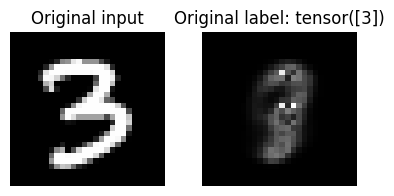

In [62]:
def metric_aware_sample(model: IRVAE, x, devivce, sigma=1.0):
    mean, log_var = model.encoder(x.to(device))
    z0 = mean
    z_sampled = model.reparameterize(mean, log_var)
    with torch.no_grad():
        G = get_pullbacked_Riemannian_metric(model.decoder, z0)   # (B, d, d)
        # Symmetrize and eigendecompose
        G = 0.5 * (G + G.transpose(-1, -2))
        eigvals, eigvecs = torch.linalg.eigh(G)

        # Avoid numerical instabilities
        eigvals = torch.clamp(eigvals, min=1e-6)
        G_inv_sqrt = eigvecs @ torch.diag_embed(1.0 / torch.sqrt(eigvals)) @ eigvecs.transpose(-1, -2)

        eps = torch.randn_like(z0)
        z_new = z0 + sigma * (G_inv_sqrt @ eps.unsqueeze(-1)).squeeze(-1)
        output = model.decoder(z_new)
        return output, z_new

trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=0)
x, y = next(iter(trainloader))
sampled_x, z_new = metric_aware_sample(irvae, x, device)
sampled_x = sampled_x.reshape_as(next(iter(trainloader))[0])

img1_np = x.squeeze().detach().cpu().numpy()
img2_np = sampled_x.squeeze().detach().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(4, 2))
axes[0].imshow(img1_np, cmap="gray", vmin=0, vmax=1)
axes[0].set_title("Original input")
axes[0].axis("off")

axes[1].imshow(img2_np, cmap="gray", vmin=0, vmax=1)
axes[1].set_title("Sampled input")
axes[1].axis("off")

plt.tight_layout()
plt.title(f"Original label: {y}")
plt.show()

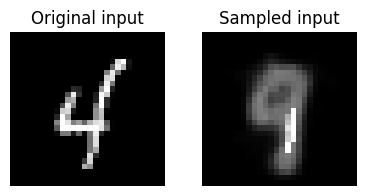

In [14]:
# VAE experiment
from models.irvae import IRVAE


def metric_aware_sample(model: IRVAE | VariationalAutoencoder, x, device, sigma=1.0):
    mean, log_var = model.encoder(x.to(device))
    z0 = mean
    z_sampled = model.reparameterize(mean, log_var)
    with torch.no_grad():
        G = get_pullbacked_Riemannian_metric(model.decoder, z0)   # (B, d, d)
        # Symmetrize and eigendecompose
        G = 0.5 * (G + G.transpose(-1, -2))
        eigvals, eigvecs = torch.linalg.eigh(G)

        # Avoid numerical instabilities
        eigvals = torch.clamp(eigvals, min=1e-6)
        G_inv_sqrt = eigvecs @ torch.diag_embed(1.0 / torch.sqrt(eigvals)) @ eigvecs.transpose(-1, -2)

        eps = torch.randn_like(z0)
        z_new = z0 + sigma * (G_inv_sqrt @ eps.unsqueeze(-1)).squeeze(-1)
        output = model.decoder(z_new)
        return output, z_new

trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=0)
x, y = next(iter(trainloader))
sampled_x, z_new = metric_aware_sample(vae, x, device)
sampled_x = sampled_x.reshape_as(next(iter(trainloader))[0])

img1_np = x.squeeze().detach().cpu().numpy()
img2_np = sampled_x.squeeze().detach().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(4, 2))
axes[0].imshow(img1_np, cmap="gray", vmin=0, vmax=1)
axes[0].set_title("Original input")
axes[0].axis("off")

axes[1].imshow(img2_np, cmap="gray", vmin=0, vmax=1)
axes[1].set_title("Sampled input")
axes[1].axis("off")

plt.tight_layout()
plt.show()

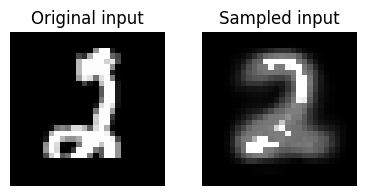

In [10]:
# VAE experiment
from models.irvae import IRVAE


def gaussian_sampling(model: IRVAE | VariationalAutoencoder, x, device, sigma=1.0):
    mean, log_var = model.encoder(x.to(device))
    return model.encoder(mean)
    # return model(x.to(device))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=0)
x, y = next(iter(trainloader))
sampled_x, z_new = metric_aware_sample(vae, x, device)
sampled_x = sampled_x.reshape_as(next(iter(trainloader))[0])

img1_np = x.squeeze().detach().cpu().numpy()
img2_np = sampled_x.squeeze().detach().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(4, 2))
axes[0].imshow(img1_np, cmap="gray", vmin=0, vmax=1)
axes[0].set_title("Original input")
axes[0].axis("off")

axes[1].imshow(img2_np, cmap="gray", vmin=0, vmax=1)
axes[1].set_title("Sampled input")
axes[1].axis("off")

plt.tight_layout()
plt.show()

## Conditional Variational Autoencoder (CVAE)

## RBF-model VAE Riemann Manifold... you know the one

## Ensemble-based Approach one

The structure for each section should be the following:

1. Load pretrained model (trained in the training.ipynb)
2. Sampling methods:
    2a. Show a 5 Gaussian samples given an input data.
    2b. Show 5 metric-aware samples using the Riemann metric.
3. Uncertainty using sampling methods
    3a. Given a correct prediction, take 5 gaussian samples for the input data. Run predictions on the reconstructed samples. Check the confidence based on number of "votes" on the class. Do the same but using metric-aware sampling.
    3b. Given a misprediction, do the same.
    3c. Given an OOD, check the predictions.
4. Uncertainty using distance measures
    4a. Use a precomputed table of the locations of the input data and class on the latent space chart. Then, compare the intraclass and interclass distance of a given test point in the latent space (the prediction of the predictive model is used to check the "class"). Find a good clustering distance measure, so I can compare. If the intraclass distance is high and interclass distance (or distance to a single other class) is low, there should be higher uncertainty and vice versa.
    4b. Do the same, but compute the geodesic between everypoint. Maybe I can cache the Jacobians for the training data to save time? If not, I will need to use the whole training set to compute just one geodesic.
